### Import Libraries

In [1]:
!pip install liac-arff

# Bagging Models

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import arff
import requests

from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


### Import Data

In [3]:
hr_arff = requests.get('https://raw.githubusercontent.com/juwon0502/MIS-373-Predictive-Analytics/master/datasets/HR_employee_attrition.arff')
hr_arff = arff.load(hr_arff.text)
col_val = [attribute[0] for attribute in hr_arff['attributes']]
hr_df = pd.DataFrame(hr_arff['data'], columns = col_val)
meta = hr_arff['attributes']

In [4]:
def clean_df(df):
  cols = list(df.columns)
  for col in cols:
    try:
      df = df.replace({col: {'Yes': 1, 'No': 0}})
    except:
      pass
  return df

hr_df = clean_df(hr_df)
hr_df_dummies = pd.get_dummies(hr_df)

### Visualize Attributes

In [5]:
def display_attribute(df, meta, col_name):
  pep = df.loc[df['Attrition'] == 1]
  pep_col_name = []
  no_pep_col_name = []
  if type(meta[col_val.index(col_name)][1]) == list:
    labels = meta[col_val.index(col_name)][1]
    for label in labels:
      no_pep_col_name.append(len(df.loc[df[col_name] == label]))
      pep_col_name.append(len(pep.loc[pep[col_name] == label]))

  else:
    labels = []
    min_val = int(min(df[col_name]))
    max_val = int(max(df[col_name]))
    rg = max_val - min_val
    if rg < 12:
      for x in range(min_val, max_val + 1):
        no_pep_col_name.append(len(df.loc[df[col_name] == x]))
        pep_col_name.append(len(pep.loc[pep[col_name] == x]))
        labels.append(x)
    else:
      for y in range(min_val, max_val, (rg//8)):
        no_pep_col_name.append(len(df.loc[df[col_name].between(y, y + (rg//8))]))
        pep_col_name.append(len(pep.loc[pep[col_name].between(y, y + (rg//8))]))
        labels.append(f"{y}-{y+(rg//8-1)}")

  if type(labels[0]) != str:
    labels = [str(label) for label in labels]
  plt.figure(dpi = 150)
  plt.bar(labels, no_pep_col_name, label = 'No attrition')
  plt.bar(labels, pep_col_name, label = 'Yes attrition')
  plt.legend()
  plt.title(f'{col_name} distribution')
  plt.show()

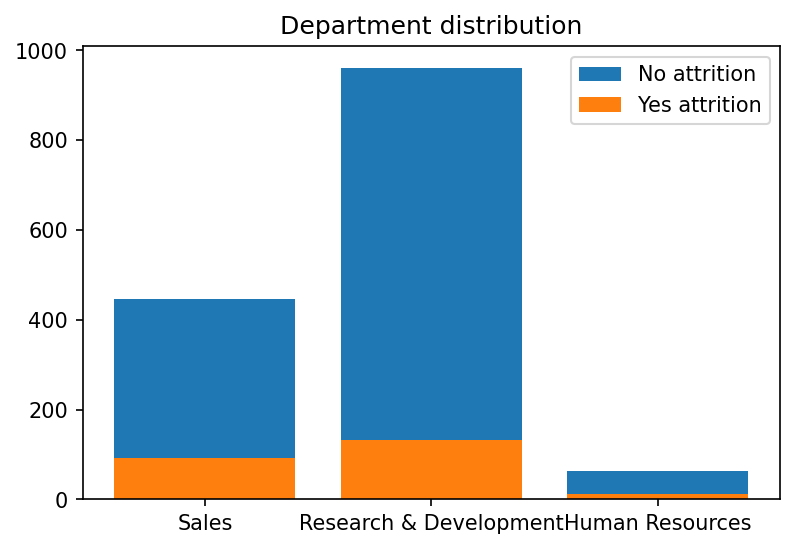

In [6]:
display_attribute(hr_df, meta, 'Department') # Change third parameter to change attribute

### Create Random Forest Model

In [7]:
X = hr_df_dummies.drop(columns=['Attrition'])
y = hr_df_dummies.Attrition
# max_features = int(input("How many features (between 4-6)? "))
max_features = 5
random_forest_model = RandomForestClassifier(criterion = 'entropy', max_features = max_features, n_estimators = 330, random_state = 42).fit(X,y)

### Create Bagging Model

In [8]:
X = hr_df_dummies.drop(columns=['Attrition'])
y = hr_df_dummies.Attrition
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)
# How many times we resample
# n_estimators = int(input("Number of estimators "))
n_estimators = 20
# Need the base estimator, the CT model, before creating the bagging model
bagging_model = BaggingClassifier(base_estimator=clf, n_estimators=n_estimators, random_state=0).fit(X, y)

### Creating KNN Model

In [9]:
#KNN model performance with bagging
from sklearn.neighbors import KNeighborsClassifier
KNNmodel = KNeighborsClassifier(n_neighbors=7)
KNNmodel.fit(X, y)

KNeighborsClassifier(n_neighbors=7)

### Creating Linear Regression Model

In [10]:
#Logistic regression model performance with bagging
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression()
LRmodel.fit(X, y)

d:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Evaluation

In [11]:
#Decision tree CV
dt_model = DecisionTreeClassifier(criterion='entropy').fit(X,y)
dt_scores = cross_val_score(dt_model, X, y, cv=10, scoring='roc_auc')
dt_accuracy = dt_scores.mean()
# stf = dt_scores.std()
# print(f"#### {round(scores.mean(),4)} accuracy with a standard deviation of {round(scores.std(),4)}")

#Bagging with CT performance
bagging_scores = cross_val_score(bagging_model, X, y, cv=10)
bagging_CT_accuracy = bagging_scores.mean()
# std = bagging_scores.std()
# print(f"#### {round(scores.mean(),4)} accuracy with a standard deviation of {round(scores.std(),4)}")

#Bagging with CT performance
bagging_scores_auc = cross_val_score(bagging_model, X, y, cv=10, scoring = 'roc_auc')
bagging_CT_accuracy_auc = bagging_scores_auc.mean()
# std = bagging_scores.std()
# print(f"#### {round(scores.mean(),4)} accuracy with a standard deviation of {round(scores.std(),4)}")

#Random forest performance
rf_scores = cross_val_score(random_forest_model, X, y, cv=10, scoring='roc_auc')
rf_accuracy = rf_scores.mean()
# std = rf_scores.std()
# print(f"#### {round(scores.mean(),4)} accuracy with a standard deviation of {round(scores.std(),4)}")

#Bagging with KNN performance
bagging_model_KNN = BaggingClassifier(base_estimator=KNNmodel, n_estimators=n_estimators, random_state=0).fit(X, y)
bagging_KNN_accuracy = cross_val_score(bagging_model_KNN, X, y, cv=10, scoring = 'roc_auc').mean()

#Bagging with LR performance
bagging_model_LR = BaggingClassifier(base_estimator=LRmodel, n_estimators=n_estimators, random_state=0).fit(X, y)
bagging_LR_accuracy = cross_val_score(bagging_model_LR, X, y, cv=10, scoring = 'roc_auc').mean()

print(f"Decision Tree with CV AUC: {round(dt_accuracy,4)}")
print(f"Random Forest with CV AUC: {round(rf_accuracy,4)}")
print(f"Bagging (CT as base) with CV: {round(bagging_CT_accuracy,4)}")
print(f"Bagging (CT as base) with CV AUC: {round(bagging_CT_accuracy_auc,4)}")
print(f"Bagging (KNN as base) with CV AUC: {round(bagging_KNN_accuracy,4)}")
print(f"Bagging (LR as base) with CV AUC: {round(bagging_LR_accuracy,4)}")

d:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Decision Tree with CV AUC: 0.615
Random Forest with CV AUC: 0.8117
Bagging (CT as base) with CV: 0.8605
Bagging (CT as base) with CV AUC: 0.7848
Bagging (KNN as base) with CV AUC: 0.6081
Bagging (LR as base) with CV AUC: 0.6903


d:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result